In [1]:
%load_ext autoreload
%autoreload 2

Simple case study. We have a csv file with wind turbine data.

# Installation

In [2]:
!pip install xgboost matplotlib
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Loading Data

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [4]:
power_data = pd.read_csv("artifacts/power_cleaned_data.csv")

bin_edges = range(0, int(power_data["Patv"].max()) + 100, 100)

# Bin the Patv column
power_data["Patv"] = pd.cut(
    power_data["Patv"], bins=bin_edges, labels=False, right=False
)

power_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,53,20:00,7.96,3.38,34.93,45.50,212.74,1.00,1.00,1.00,-0.23,8
1,1,53,20:10,8.97,-1.94,34.90,45.54,207.82,1.00,1.00,1.00,-0.21,10
2,1,53,20:20,8.98,5.65,34.85,45.58,220.33,1.00,1.00,1.00,-0.20,11
3,1,53,20:30,8.12,1.19,34.52,45.49,251.20,1.00,1.00,1.00,-0.20,9
4,1,53,20:40,5.89,-1.71,34.24,45.46,249.54,0.99,0.99,0.99,-0.24,4


In [5]:
class DataCleaner:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Apply all abnormal conditions to filter out invalid data
        conditions = [
            self.data["Patv"] < 0,
            (self.data["Wspd"] < 1) & (self.data["Patv"] > 10),
            (self.data["Wspd"] < 2) & (self.data["Patv"] > 100),
            (self.data["Wspd"] < 3) & (self.data["Patv"] > 200),
            (self.data["Wspd"] > 2.5) & (self.data["Patv"] == 0),
            (self.data["Wspd"] == 0)
            & (self.data["Wdir"] == 0)
            & (self.data["Etmp"] == 0),
            self.data["Etmp"] < -21,
            self.data["Itmp"] < -21,
            self.data["Etmp"] > 60,
            self.data["Itmp"] > 70,
            (self.data["Wdir"] > 180) | (self.data["Wdir"] < -180),
            (self.data["Ndir"] > 720) | (self.data["Ndir"] < -720),
            (self.data["Pab1"] > 89)
            | (self.data["Pab2"] > 89)
            | (self.data["Pab3"] > 89),
        ]

        self.data["Patv"] = self.data["Patv"].astype(int)

        # Combine all conditions with OR operator
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition |= condition

        # Filter out rows that meet any of the abnormal conditions
        self.data = self.data[~combined_condition]

        self.data = self.data.dropna()
        return self.data


# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(power_data)
cleaned_data = cleaner.clean_data()


# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
cleaned_data.head()

train, test = train_test_split(cleaned_data, test_size=0.5, random_state=42)
train

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
577,1,58,09:50,3.16,1.60,20.52,29.20,196.95,0.99,0.99,0.99,-0.23,1
2631,1,78,16:40,8.88,1.57,25.22,35.30,-1.60,1.00,1.00,1.00,-0.24,10
1851,1,71,19:50,2.14,-0.19,36.53,44.29,120.98,0.99,0.99,0.99,-0.25,0
2280,1,75,08:30,3.15,-1.29,27.42,36.48,31.15,0.99,0.99,0.99,-0.23,1
3103,1,82,10:50,4.23,1.02,30.59,39.32,192.70,0.99,0.99,0.99,-0.21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,1,64,21:30,10.24,-0.43,33.36,44.09,69.93,1.00,1.00,1.00,-0.26,13
1357,1,67,15:30,10.34,1.75,39.74,51.45,49.58,1.02,1.02,1.02,-0.22,12
898,1,61,12:50,1.89,-12.24,29.20,36.59,221.58,1.00,1.00,1.90,0.00,0
3751,1,89,01:00,10.52,-1.63,35.17,45.99,15.60,1.00,1.00,1.00,-0.31,14


In [6]:
# encode Tmstamp column to numeric values
train["Tmstamp"] = pd.to_datetime(train["Tmstamp"]).astype(int) // 10**9
test["Tmstamp"] = pd.to_datetime(test["Tmstamp"]).astype(int) // 10**9

/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_26086/2176833310.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train["Tmstamp"] = pd.to_datetime(train["Tmstamp"]).astype(int) // 10**9
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_26086/2176833310.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test["Tmstamp"] = pd.to_datetime(test["Tmstamp"]).astype(int) // 10**9


<Axes: >

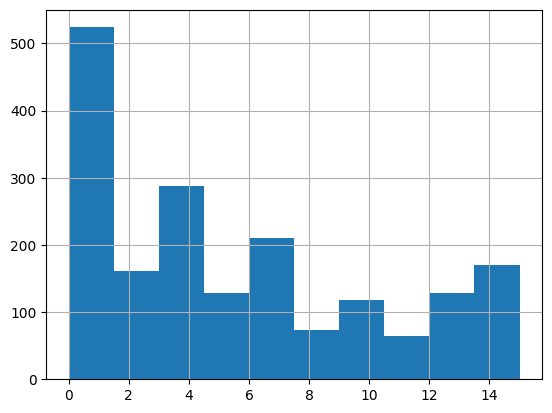

In [7]:
train["Patv"].hist()

<Axes: >

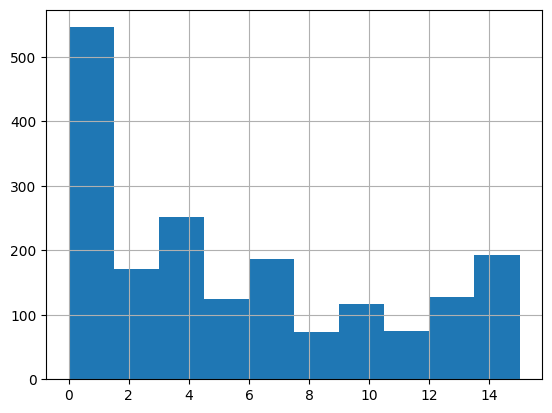

In [8]:
test["Patv"].hist()

## Train Classifier

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


# Split the data into training and testing sets
X = train.drop(columns=["Patv"])
y = train["Patv"]

X_test = test.drop(columns=["Patv"])
y_test = test["Patv"]

#original_model = XGBClassifier()

# another alternative model in pytorch
from torch import nn
import torch
class OurModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(OurModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    


original_model = OurModel(input_size=12, hidden_size=100, num_classes=16)


X_train_tensor = torch.tensor(X.values).long()
y_train_tensor = torch.tensor(y.values).long()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model.to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(original_model.parameters(), lr=0.001)

num_epochs = 10


In [10]:

for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_loader):

        print(i)
        print(X_batch.shape)
        print(y_batch.shape)


        optimizer.zero_grad()
        # change to float
        X_batch = X_batch.float().to(device)
        
        outputs = original_model(X_batch)
        sddwe
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}, Loss: {loss.item()}")


0
torch.Size([32, 12])
torch.Size([32])


NameError: name 'sddwe' is not defined

In [11]:
outputs.shape

torch.Size([32, 16])

In [12]:
y_batch.shape

torch.Size([32])

In [13]:
y_batch

tensor([ 4,  1,  9, 14,  1, 12,  3,  3,  1, 15,  0,  1,  7,  3,  7,  1,  8,  4,
        14,  8, 15,  8, 15,  3, 12,  2, 15,  3,  1, 13,  0,  0])

In [14]:
criterion(outputs, y_batch)

: 

In [ ]:
X_test_tensor = torch.tensor(X_test.values).long()
y_test_tensor = torch.tensor(y_test.values).long()

X_test_tensor = X_test_tensor.float().to(device)

outputs = original_model(X_test_tensor)
_, y_pred = torch.max(outputs, 1)

y_pred = y_pred.cpu().numpy()



# Calculate precision, recall, and F1 score, classification report
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(classification_report(y_test, y_pred))


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
from synthetic_energy.attacks import CarliniWagnerAttack
import torch


cw = CarliniWagnerAttack(
    device="cpu"
)

x_text_float = X_test.values.astype(float)
y_test_float = y_test.values.astype(float)
y_test_dataloader = torch.utils.data.DataLoader(
    #Join x and y
    list(zip(x_text_float, y_test_float)),
    batch_size=1, shuffle=False
)

adv_examples, all_examples = cw.attack(original_model, y_test_dataloader)

In [ ]:
# see model layers
print(original_model)
# see model weights
print(original_model.state_dict())

# see first layer weights
print(original_model.fc1.weight.dtype)
